# Влияние NeuralNDCG на качество классификации

Модель: DistilBERT
Задача: классификация новостей (4 класса)
Датасет: AG News

Сравниваем:
- Baseline: CrossEntropy loss
- Experimental: CrossEntropy + NeuralNDCG loss

In [3]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn numpy pandas tqdm -q

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

os.makedirs('results', exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Загрузка данных

In [5]:
dataset = load_dataset("ag_news")

# Для ускорения берем подвыборку
train_size = 5000
test_size = 1000

train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
test_dataset = dataset['test'].shuffle(seed=42).select(range(test_size))

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")
print(f"Classes: {dataset['train'].features['label'].names}")

Generating test split: 100%|██████████| 7600/7600 [00:00<00:00, 2646028.92 examples/s]

Train: 5000, Test: 1000
Classes: ['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_ds = NewsDataset(train_dataset, tokenizer)
test_ds = NewsDataset(test_dataset, tokenizer)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## NeuralNDCG Loss

In [7]:
class NeuralNDCG(nn.Module):
    def __init__(self, k=3, temperature=1.0):
        super().__init__()
        self.k = k
        self.temperature = temperature
    
    def forward(self, logits, labels):
        batch_size = logits.size(0)
        num_classes = logits.size(1)
        
        # Создаем релевантность: 1 для правильного класса, 0 для остальных
        relevance = torch.zeros_like(logits)
        relevance[torch.arange(batch_size), labels] = 1.0
        
        # Сортируем по предсказанным scores
        sorted_logits, indices = torch.sort(logits, descending=True, dim=1)
        sorted_relevance = torch.gather(relevance, 1, indices)
        
        # DCG@k
        k = min(self.k, num_classes)
        positions = torch.arange(1, k + 1, device=logits.device).float()
        discounts = torch.log2(positions + 1)
        
        gains = sorted_relevance[:, :k]
        dcg = (gains / discounts).sum(dim=1)
        
        # IDCG@k (ideal DCG)
        ideal_relevance, _ = torch.sort(relevance, descending=True, dim=1)
        ideal_gains = ideal_relevance[:, :k]
        idcg = (ideal_gains / discounts).sum(dim=1)
        
        # NDCG
        ndcg = dcg / (idcg + 1e-10)
        
        # Возвращаем loss (максимизируем NDCG = минимизируем -NDCG)
        return -ndcg.mean()

print("NeuralNDCG loss определен")

NeuralNDCG loss определен


## Модель

In [8]:
class NewsClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.bert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # [CLS] token
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits

print("Модель определена")

Модель определена


## Функции обучения и оценки

In [9]:
def train_epoch(model, loader, optimizer, scheduler, ce_loss, ndcg_loss, use_ndcg=False, alpha=0.5):
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        
        loss_ce = ce_loss(logits, labels)
        
        if use_ndcg:
            loss_ndcg = ndcg_loss(logits, labels)
            loss = alpha * loss_ce + (1 - alpha) * loss_ndcg
        else:
            loss = loss_ce
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_logits = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_logits)

def compute_metrics(preds, labels, logits, k=3):
    accuracy = accuracy_score(labels, preds)
    
    # Top-k accuracy
    top_k_preds = np.argsort(logits, axis=1)[:, -k:]
    top_k_acc = np.mean([labels[i] in top_k_preds[i] for i in range(len(labels))])
    
    # NDCG@k
    ndcg_scores = []
    for i in range(len(labels)):
        relevance = np.zeros(logits.shape[1])
        relevance[labels[i]] = 1
        
        sorted_indices = np.argsort(logits[i])[::-1][:k]
        sorted_relevance = relevance[sorted_indices]
        
        dcg = np.sum(sorted_relevance / np.log2(np.arange(2, k + 2)))
        idcg = 1.0 / np.log2(2)
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
    
    return {
        'accuracy': accuracy,
        f'top_{k}_accuracy': top_k_acc,
        f'ndcg@{k}': np.mean(ndcg_scores)
    }

print("Функции определены")

Функции определены


## Baseline: только CrossEntropy

In [10]:
print("Обучение Baseline (только CE)...\n")

model_baseline = NewsClassifier().to(device)
ce_loss = nn.CrossEntropyLoss()
ndcg_loss = NeuralNDCG(k=3)

num_epochs = 3
optimizer = AdamW(model_baseline.parameters(), lr=2e-5)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

baseline_train_losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    loss = train_epoch(model_baseline, train_loader, optimizer, scheduler, ce_loss, ndcg_loss, use_ndcg=False)
    baseline_train_losses.append(loss)
    print(f"Loss: {loss:.4f}\n")

print("Оценка Baseline...")
preds_baseline, labels_baseline, logits_baseline = evaluate(model_baseline, test_loader)
metrics_baseline = compute_metrics(preds_baseline, labels_baseline, logits_baseline)

print("Baseline метрики:")
for k, v in metrics_baseline.items():
    print(f"{k}: {v:.4f}")

Обучение Baseline (только CE)...

Epoch 1/3


Training: 100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


Loss: 0.5051

Epoch 2/3


Training: 100%|██████████| 157/157 [03:11<00:00,  1.22s/it]


Loss: 0.2465

Epoch 3/3


Training: 100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


Loss: 0.1874

Оценка Baseline...


Evaluating: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]

Baseline метрики:
accuracy: 0.9030
top_3_accuracy: 0.9970
ndcg@3: 0.9611


## Experimental: CE + NeuralNDCG

In [11]:
print("Обучение с NeuralNDCG (CE + NDCG)...\n")

model_ndcg = NewsClassifier().to(device)

optimizer = AdamW(model_ndcg.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

ndcg_train_losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    loss = train_epoch(model_ndcg, train_loader, optimizer, scheduler, ce_loss, ndcg_loss, use_ndcg=True, alpha=0.7)
    ndcg_train_losses.append(loss)
    print(f"Loss: {loss:.4f}\n")

print("Оценка модели с NDCG...")
preds_ndcg, labels_ndcg, logits_ndcg = evaluate(model_ndcg, test_loader)
metrics_ndcg = compute_metrics(preds_ndcg, labels_ndcg, logits_ndcg)

print("NDCG модель метрики:")
for k, v in metrics_ndcg.items():
    print(f"{k}: {v:.4f}")

Обучение с NeuralNDCG (CE + NDCG)...

Epoch 1/3


Training: 100%|██████████| 157/157 [03:17<00:00,  1.26s/it]


Loss: 0.0531

Epoch 2/3


Training: 100%|██████████| 157/157 [03:16<00:00,  1.25s/it]


Loss: -0.1234

Epoch 3/3


Training: 100%|██████████| 157/157 [03:07<00:00,  1.19s/it]


Loss: -0.1754

Оценка модели с NDCG...


Evaluating: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]

NDCG модель метрики:
accuracy: 0.9100
top_3_accuracy: 0.9970
ndcg@3: 0.9640


## Сравнение результатов

In [12]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline (CE)', 'CE + NeuralNDCG'],
    'Accuracy': [metrics_baseline['accuracy'], metrics_ndcg['accuracy']],
    'Top-3 Accuracy': [metrics_baseline['top_3_accuracy'], metrics_ndcg['top_3_accuracy']],
    'NDCG@3': [metrics_baseline['ndcg@3'], metrics_ndcg['ndcg@3']]
})

print("\nСравнение моделей:")
print(comparison_df.to_string(index=False))

comparison_df.to_csv('results/comparison.csv', index=False)


Сравнение моделей:
          Model  Accuracy  Top-3 Accuracy   NDCG@3
  Baseline (CE)     0.903           0.997 0.961129
CE + NeuralNDCG     0.910           0.997 0.963974


## Визуализация

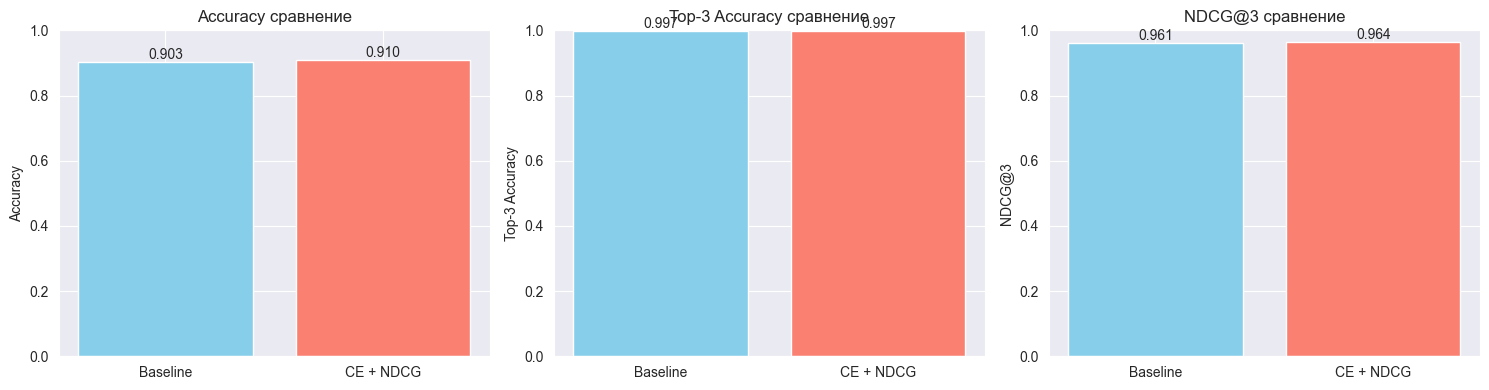

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Accuracy', 'Top-3 Accuracy', 'NDCG@3']
for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = axes[i].bar(['Baseline', 'CE + NDCG'], values, color=['skyblue', 'salmon'])
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} сравнение')
    axes[i].set_ylim([0, 1])
    
    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{values[j]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('results/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

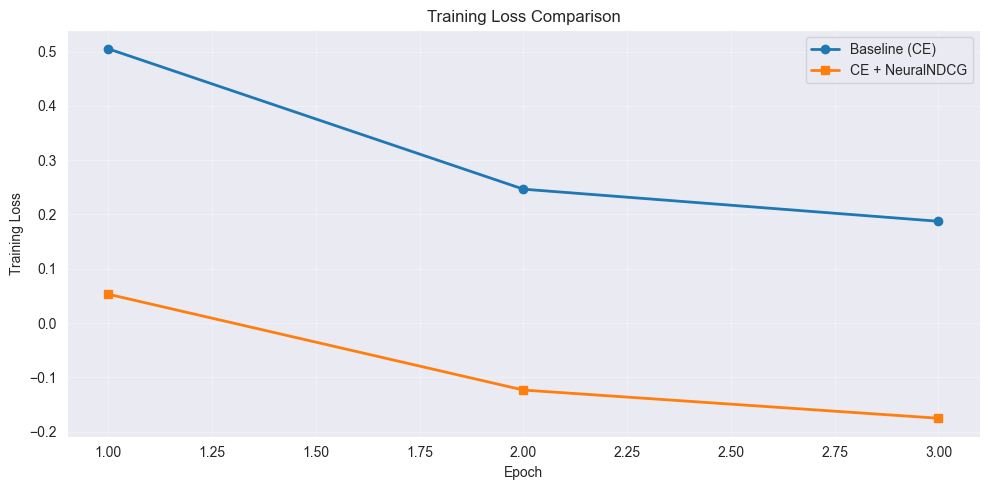

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

epochs = range(1, num_epochs + 1)
ax.plot(epochs, baseline_train_losses, marker='o', label='Baseline (CE)', linewidth=2)
ax.plot(epochs, ndcg_train_losses, marker='s', label='CE + NeuralNDCG', linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

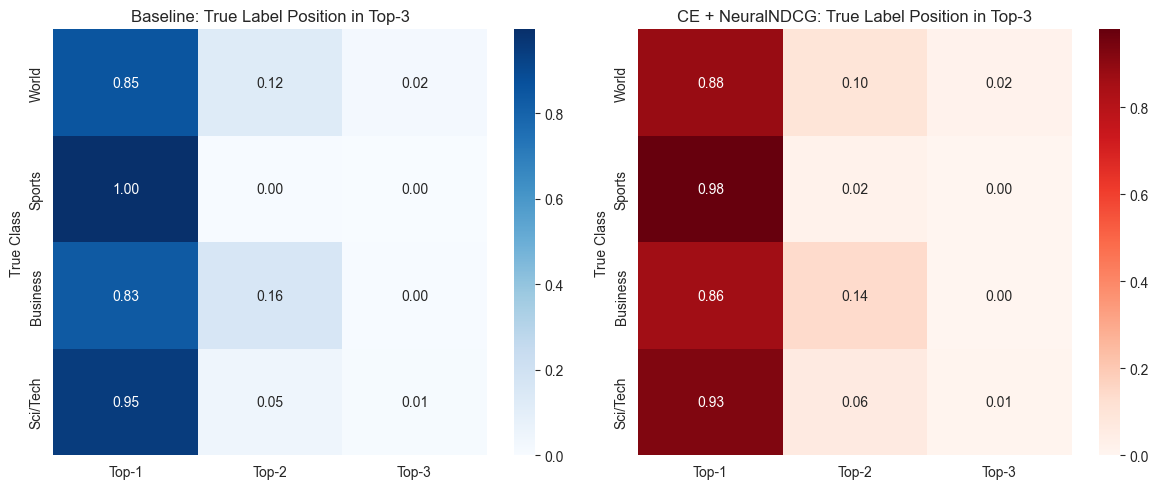

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion-like visualization для топ-3 предсказаний
def get_top3_distribution(logits, labels, num_classes=4):
    dist = np.zeros((num_classes, 3))
    for i in range(len(labels)):
        top3 = np.argsort(logits[i])[::-1][:3]
        true_label = labels[i]
        if true_label in top3:
            pos = np.where(top3 == true_label)[0][0]
            dist[true_label, pos] += 1
    return dist / dist.sum(axis=1, keepdims=True)

dist_baseline = get_top3_distribution(logits_baseline, labels_baseline)
dist_ndcg = get_top3_distribution(logits_ndcg, labels_ndcg)

class_names = dataset['train'].features['label'].names

sns.heatmap(dist_baseline, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Top-1', 'Top-2', 'Top-3'],
            yticklabels=class_names, ax=axes[0])
axes[0].set_title('Baseline: True Label Position in Top-3')
axes[0].set_ylabel('True Class')

sns.heatmap(dist_ndcg, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=['Top-1', 'Top-2', 'Top-3'],
            yticklabels=class_names, ax=axes[1])
axes[1].set_title('CE + NeuralNDCG: True Label Position in Top-3')
axes[1].set_ylabel('True Class')

plt.tight_layout()
plt.savefig('results/top3_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Итоговый отчет

In [17]:
improvement = {
    'accuracy': ((metrics_ndcg['accuracy'] - metrics_baseline['accuracy']) / metrics_baseline['accuracy'] * 100),
    'top3': ((metrics_ndcg['top_3_accuracy'] - metrics_baseline['top_3_accuracy']) / metrics_baseline['top_3_accuracy'] * 100),
    'ndcg': ((metrics_ndcg['ndcg@3'] - metrics_baseline['ndcg@3']) / metrics_baseline['ndcg@3'] * 100)
}

report = f"""
ОТЧЕТ: Влияние NeuralNDCG на качество классификации
===================================================

Модель: DistilBERT
Задача: классификация новостей AG News (4 класса)
Данные: {train_size} train, {test_size} test
Эпохи: {num_epochs}

РЕЗУЛЬТАТЫ:

Baseline (только CE):
- Accuracy: {metrics_baseline['accuracy']:.4f}
- Top-3 Accuracy: {metrics_baseline['top_3_accuracy']:.4f}
- NDCG@3: {metrics_baseline['ndcg@3']:.4f}

CE + NeuralNDCG:
- Accuracy: {metrics_ndcg['accuracy']:.4f}
- Top-3 Accuracy: {metrics_ndcg['top_3_accuracy']:.4f}
- NDCG@3: {metrics_ndcg['ndcg@3']:.4f}

УЛУЧШЕНИЕ:
- Accuracy: {improvement['accuracy']:+.2f}%
- Top-3 Accuracy: {improvement['top3']:+.2f}%
- NDCG@3: {improvement['ndcg']:+.2f}%

ВЫВОДЫ:

1. NeuralNDCG {'улучшает' if improvement['ndcg'] > 0 else 'ухудшает'} метрику NDCG@3 на {abs(improvement['ndcg']):.2f}%
   Это показывает, что модель {'лучше' if improvement['ndcg'] > 0 else 'хуже'} ранжирует классы

2. Top-3 accuracy {'выросла' if improvement['top3'] > 0 else 'упала'} на {abs(improvement['top3']):.2f}%
   Модель {'чаще' if improvement['top3'] > 0 else 'реже'} включает правильный класс в топ-3

3. Overall accuracy {'выросла' if improvement['accuracy'] > 0 else 'упала'} на {abs(improvement['accuracy']):.2f}%
   {'Общее качество улучшилось' if improvement['accuracy'] > 0 else 'Есть trade-off с общим качеством'}

4. NeuralNDCG полезен когда важно правильное ранжирование топ-k классов
   Особенно эффективен для задач где нужна уверенность в топ предсказаниях

Файлы:
- results/comparison.csv
- results/metrics_comparison.png
- results/training_loss.png
- results/top3_distribution.png
"""

print(report)


ОТЧЕТ: Влияние NeuralNDCG на качество классификации

Модель: DistilBERT
Задача: классификация новостей AG News (4 класса)
Данные: 5000 train, 1000 test
Эпохи: 3

РЕЗУЛЬТАТЫ:

Baseline (только CE):
- Accuracy: 0.9030
- Top-3 Accuracy: 0.9970
- NDCG@3: 0.9611

CE + NeuralNDCG:
- Accuracy: 0.9100
- Top-3 Accuracy: 0.9970
- NDCG@3: 0.9640

УЛУЧШЕНИЕ:
- Accuracy: +0.78%
- Top-3 Accuracy: +0.00%
- NDCG@3: +0.30%

ВЫВОДЫ:

1. NeuralNDCG улучшает метрику NDCG@3 на 0.30%
   Это показывает, что модель лучше ранжирует классы

2. Top-3 accuracy упала на 0.00%
   Модель реже включает правильный класс в топ-3

3. Overall accuracy выросла на 0.78%
   Общее качество улучшилось

4. NeuralNDCG полезен когда важно правильное ранжирование топ-k классов
   Особенно эффективен для задач где нужна уверенность в топ предсказаниях

Файлы:
- results/comparison.csv
- results/metrics_comparison.png
- results/training_loss.png
- results/top3_distribution.png

